## Importing libraries

In [1]:
import sys
sys.path.append('../') 
from imports import *
from sklearn.utils import resample


# Loading the datasets

In [2]:
# Loading the datasets
X_train = pd.read_csv('./breast-cancer-processed-data/X_train.csv')
y_train = pd.read_csv('./breast-cancer-processed-data/y_train.csv') 
X_val = pd.read_csv('./breast-cancer-processed-data/X_val.csv')
y_val = pd.read_csv('./breast-cancer-processed-data/y_val.csv')
X_test = pd.read_csv('./breast-cancer-processed-data/X_test.csv')
y_test = pd.read_csv('./breast-cancer-processed-data/y_test.csv')

y_train = y_train.squeeze()
y_val = y_val.squeeze()
y_test = y_test.squeeze()


In [3]:
def plot_roc_pr_curves(y_true, y_probs, n_bootstraps=1000):
    """Perform bootstrapping to calculate the confidence intervals and plot the ROC and PR curves"""
    bootstrap_auroc_scores = []
    bootstrap_average_precision_scores = []

    for _ in range(n_bootstraps):
        # Bootstrap sample (with replacement)
        indices = resample(np.arange(len(y_true)), replace=True)
        y_true_boot = y_true.iloc[indices]
        y_probs_boot = y_probs[indices]

        # Compute metrics for bootstrap sample
        bootstrap_auroc_scores.append(roc_auc_score(y_true_boot, y_probs_boot))
        bootstrap_average_precision_scores.append(average_precision_score(y_true_boot, y_probs_boot))

    # Compute confidence intervals
    auroc_lower = np.percentile(bootstrap_auroc_scores, 2.5)
    auroc_upper = np.percentile(bootstrap_auroc_scores, 97.5)
    ap_lower = np.percentile(bootstrap_average_precision_scores, 2.5)
    ap_upper = np.percentile(bootstrap_average_precision_scores, 97.5)

    # Calculate original ROC and PR curves
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    precision, recall, _ = precision_recall_curve(y_true, y_probs)
    auroc = roc_auc_score(y_true, y_probs)
    average_precision = average_precision_score(y_true, y_probs)

    # Plotting
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # ROC Curve
    ax1.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auroc:.2f})')
    ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('Receiver Operating Characteristic')
    ax1.legend(loc="lower right", title=f'95% CI: [{auroc_lower:.2f}, {auroc_upper:.2f}]')

    # Precision-Recall Curve
    ax2.plot(recall, precision, color='blue', lw=2, label=f'PR curve (area = {average_precision:.2f})')
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title('Precision-Recall Curve')
    ax2.legend(loc="lower left", title=f'95% CI: [{ap_lower:.2f}, {ap_upper:.2f}]')

    plt.show()

    # Return the confidence intervals
    return (auroc_lower, auroc_upper), (ap_lower, ap_upper)




# Logistic regression without regularization

In [4]:
# Initialize the Logistic Regression model without regularization
log_reg = LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000, random_state=1)

# Train the model on the training set
log_reg.fit(X_train, y_train)

# Predict on the validation set
y_val_pred = log_reg.predict(X_val)

# Evaluate the model on the validation set
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Set Accuracy: {val_accuracy:.4f}")

Validation Set Accuracy: 0.9341


## We are not using accuracy_score since the dataset is imbalanced and therefore using roc_auc_score and precision_score

In [5]:
# Predict probabilities
y_val_probs = log_reg.predict_proba(X_val)[:, 1]

# Compute AUROC
auroc = roc_auc_score(y_val, y_val_probs)
print(f"Area under the ROC curve: {auroc:.2f}")

# Compute Precision-Recall curve and its area
average_precision = average_precision_score(y_val, y_val_probs)
print(f"Area under the Precision-Recall curve: {average_precision:.2f}")

Area under the ROC curve: 0.94
Area under the Precision-Recall curve: 0.93


## Bootstrapping to get confidence intervals for AUROC and area under Precision-Recall Curve

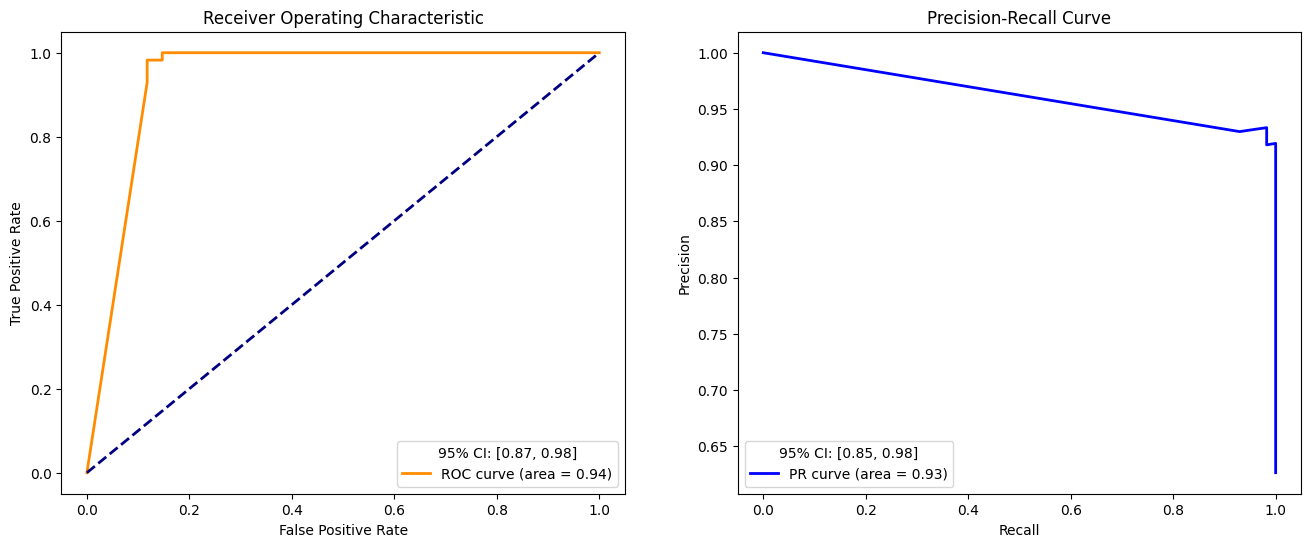

In [6]:
# AUROC and PR curves with bootstrapped 95% confidence intervals for logistic regression with no regularization
auroc_confidence_interval, ap_confidence_interval = plot_roc_pr_curves(y_val, y_val_probs)

## Logistic Regression with L1 Regularization

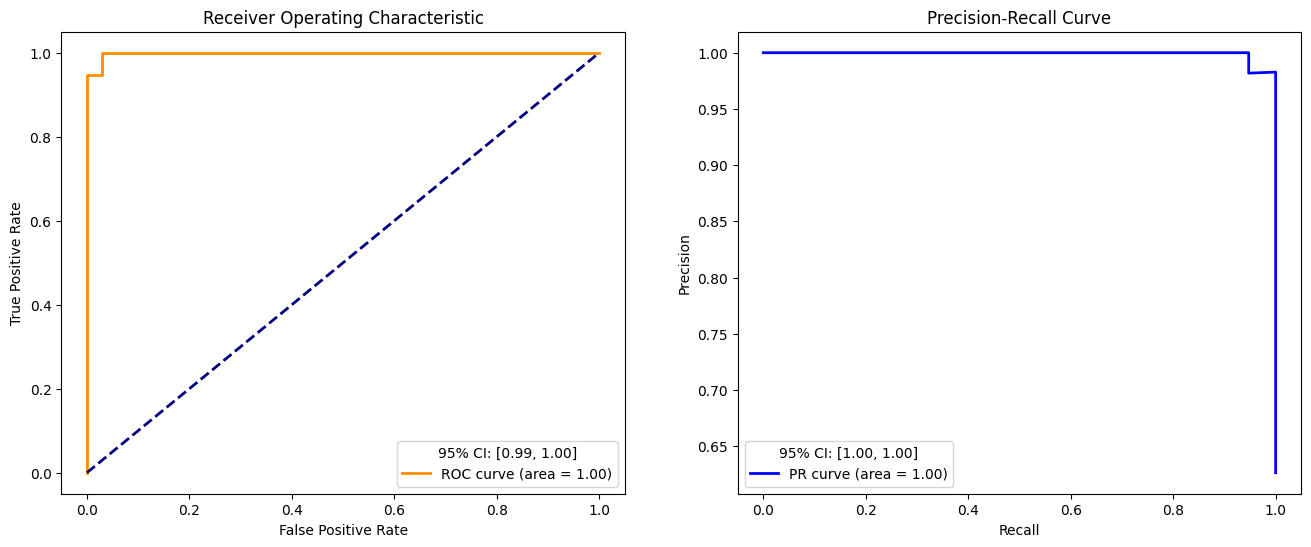

In [7]:
# Initialize the Logistic Regression model with L1 regularization
log_reg_l1 = LogisticRegression(penalty='l1', C=1.0, solver='liblinear', max_iter=1000, random_state=1)

# Train the model on the training set
log_reg_l1.fit(X_train, y_train)

# Predict probabilities for the validation and test sets
y_val_probs_l1 = log_reg_l1.predict_proba(X_val)[:, 1]
y_test_probs_l1 = log_reg_l1.predict_proba(X_test)[:, 1]

# Compute the AUROC and average precision score on the validation set
val_auroc = roc_auc_score(y_val, y_val_probs_l1)
val_average_precision = average_precision_score(y_val, y_val_probs_l1)

# Compute the AUROC and average precision score on the test set
test_auroc = roc_auc_score(y_test, y_test_probs_l1)
test_average_precision = average_precision_score(y_test, y_test_probs_l1)

# AUROC and PR curves with bootstrapped 95% confidence intervals for logistic regression with L1 regularization
auroc_confidence_interval, ap_confidence_interval = plot_roc_pr_curves(y_val, y_val_probs_l1)

## Hyperparameter tuning for C for Logistic Regression with L1 Regularization

In [9]:
# Define a set of C values to try
C_values = [0.001, 0.01, 0.1, 1, 10, 100]

# Initialize variables to store the best score and corresponding C value
best_score = 0
best_C = None

# Perform grid search over the C values
for C in C_values:
    # Initialize and train the Logistic Regression model with L1 regularization
    log_reg_l1 = LogisticRegression(penalty='l1', C=C, solver='liblinear', max_iter=1000, random_state=1)
    log_reg_l1.fit(X_train, y_train)

    # Evaluate on the validation set
    y_val_probs = log_reg_l1.predict_proba(X_val)[:, 1]
    score = roc_auc_score(y_val, y_val_probs)

    # If the score is better than the best score, update the best score and best C
    if score > best_score:
        best_score = score
        best_C = C

# Output the best C value
print(f"Best C value: {best_C} with AUROC: {best_score:.4f}")

# Train a new model using the best C value
best_log_reg_l1 = LogisticRegression(penalty='l1', C=best_C, solver='liblinear', max_iter=1000, random_state=1)
best_log_reg_l1.fit(X_train, y_train)

# Continue with bootstrapping, plotting, and evaluation using the best_log_reg_l1 model

# Predict probabilities for the validation and test sets
y_val_probs_l1 = best_log_reg_l1.predict_proba(X_val)[:, 1]

Best C value: 0.1 with AUROC: 0.9990


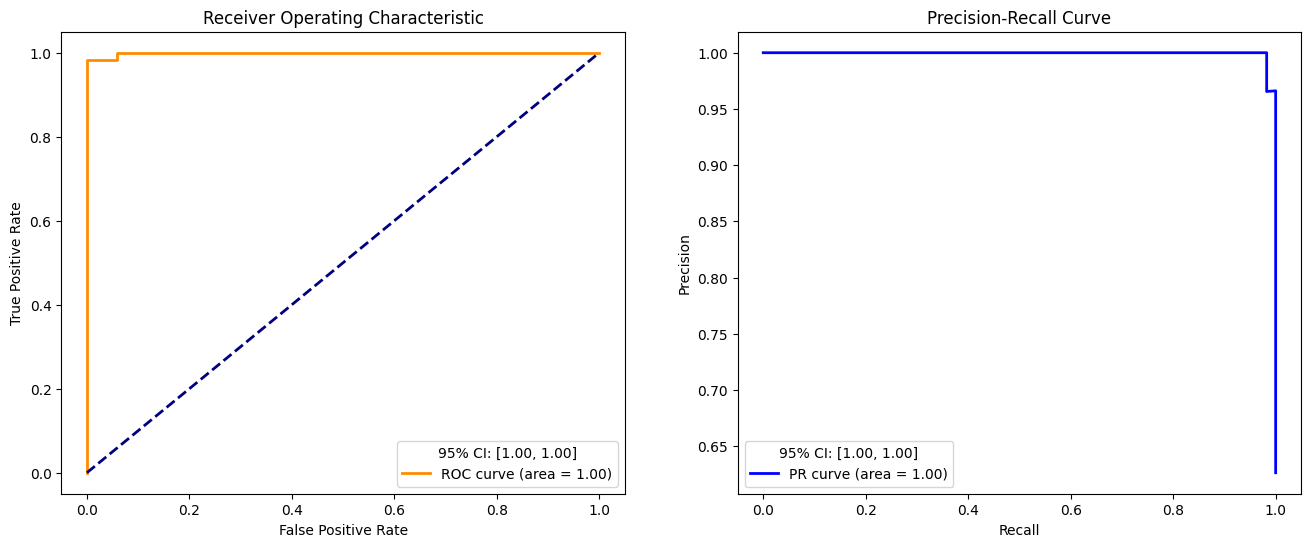

In [10]:
# AUROC and PR curves with bootstrapped 95% confidence intervals for logistic regression with L1 regularization
auroc_confidence_interval_l1, ap_confidence_interval_l1 = plot_roc_pr_curves(y_val, y_val_probs_l1)

# Logistic Regression with L2 regularization

In [11]:
# Define a logistic regression model. Note: The default penalty is 'l2'.
log_reg_l2 = LogisticRegression(solver='liblinear', random_state=1)

# Define the hyperparameter grid for 'C'. This range is quite broad, feel free to refine it based on results.
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

# Define the scoring function you want to optimize for during the grid search
scorer = make_scorer(roc_auc_score, needs_proba=True)

# Set up the grid search with cross-validation
grid_search = GridSearchCV(log_reg_l2, param_grid, cv=5, scoring=scorer)

# Perform grid search on the training set
grid_search.fit(X_train, y_train)

# Output the best C value
print(f"Best parameters: {grid_search.best_params_}")

# After grid search, the best hyperparameter value is stored in 'best_estimator_'
best_log_reg_l2 = grid_search.best_estimator_

# Now using 'best_l2_model' to make predictions and evaluate it
y_val_probs_l2 = best_log_reg_l2.predict_proba(X_val)[:, 1]

# Evaluate the model using the validation  sets
val_auroc_l2 = roc_auc_score(y_val, y_val_probs_l2)


Best parameters: {'C': 0.1}


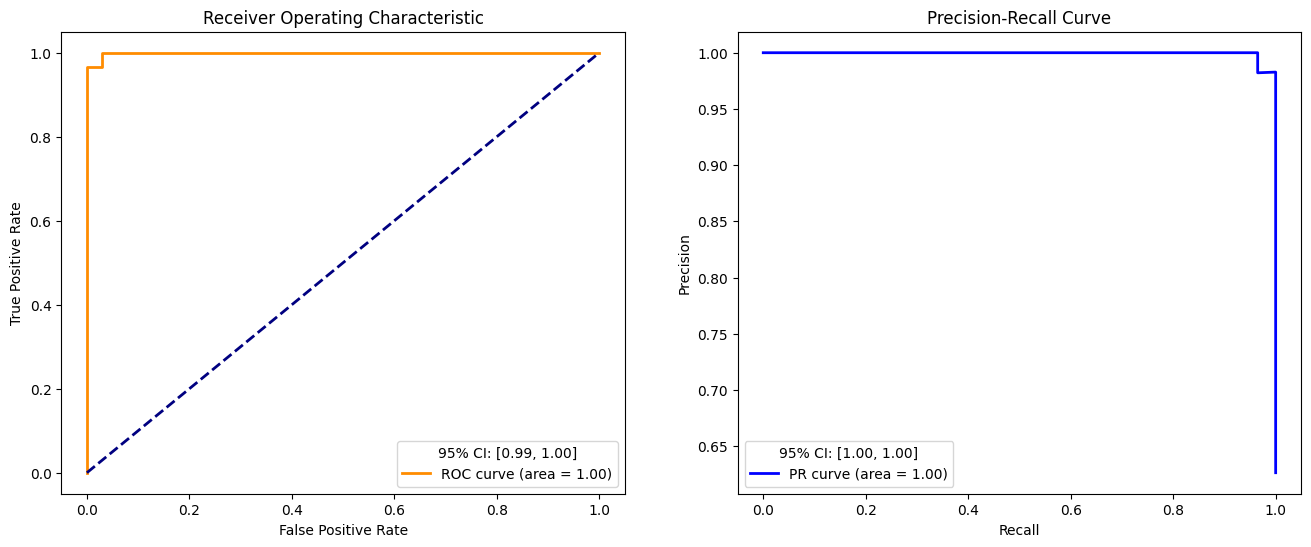

In [12]:
# AUROC and PR curves with bootstrapped 95% confidence intervals for logistic regression with L2 regularization after hyperparameter tuning
auroc_confidence_interval_l2, ap_confidence_interval_l2 = plot_roc_pr_curves(y_val, y_val_probs_l2)

# Final model: Logistic Regression with L2 Regularization with hyperparamter C = 0.1

In [13]:
# Predict on the test set
y_test_pred_l2 = best_log_reg_l2.predict(X_test)

# Predict probabilities on the test set
y_test_probs_l2 = best_log_reg_l2.predict_proba(X_test)[:, 1]



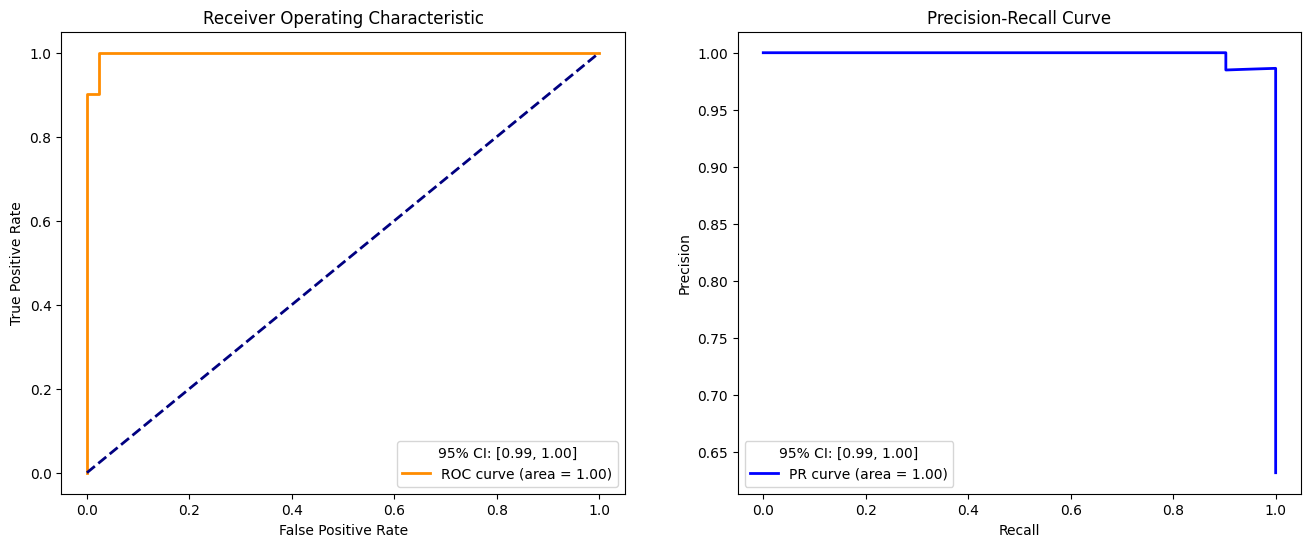

In [14]:
# AUROC and PR curves with bootstrapped 95% confidence intervals for logistic regression with L2 regularization after hyperparameter tuning on test set
auroc_confidence_interval_l2, ap_confidence_interval_l2 = plot_roc_pr_curves(y_test, y_test_probs_l2)

Test Accuracy: 0.9912
[[41  1]
 [ 0 72]]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        42
           1       0.99      1.00      0.99        72

    accuracy                           0.99       114
   macro avg       0.99      0.99      0.99       114
weighted avg       0.99      0.99      0.99       114



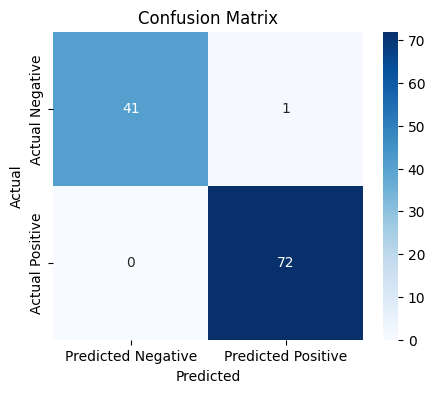

In [15]:
# Generating the confusion matrix
cm = confusion_matrix(y_test, y_test_pred_l2)
test_accuracy = accuracy_score(y_test, y_test_pred_l2)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(cm)
print(classification_report(y_test, y_test_pred_l2))


# Plotting the confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', 
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Feature importance for L1, L2 regularization

In [16]:
# Get the coefficients from the L1 model
log_reg_l1_coefficients = best_log_reg_l1.coef_.flatten()

# Get the coefficients from the L2 model
log_reg_l2_coefficients = best_log_reg_l2.coef_.flatten()

# For better interpretability, you might want to look at the absolute values of the coefficients
log_reg_l1_importance = np.abs(log_reg_l1_coefficients)
log_reg_l2_importance = np.abs(log_reg_l2_coefficients)

# Create a DataFrame for easy viewing of feature importance for both models
import pandas as pd

feature_names = X_train.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'L1 Coefficient': log_reg_l1_coefficients,
    'L1 Importance': log_reg_l1_importance,
    'L2 Coefficient': log_reg_l2_coefficients,
    'L2 Importance': log_reg_l2_importance,
}).sort_values('L1 Importance', ascending=False)

print(importance_df)


                    Feature  L1 Coefficient  L1 Importance  L2 Coefficient  \
20             worst radius       -1.683891       1.683891       -0.482595   
27     worst concave points       -1.092419       1.092419       -0.486204   
21            worst texture       -0.529278       0.529278       -0.508982   
10             radius error       -0.488518       0.488518       -0.474006   
7       mean concave points       -0.382512       0.382512       -0.400012   
24         worst smoothness       -0.185205       0.185205       -0.396941   
28           worst symmetry       -0.035923       0.035923       -0.364692   
0               mean radius        0.000000       0.000000       -0.322881   
16          concavity error        0.000000       0.000000        0.091837   
26          worst concavity        0.000000       0.000000       -0.371981   
25        worst compactness        0.000000       0.000000       -0.146645   
23               worst area        0.000000       0.000000      

# can you plot the feature importance like you did in homework #...? and interpret it..